# Market Reaction to M&A Announcements
## Do Deal Characteristics Explain Short-Term Stock Price Reactions?

This project analyzes whether observable characteristics of acquisition announcments made by publicly traded companies are associated with how much the acquirer's stock price moves on the announcement date. 

The focus is entirely on the acquiring firm, NOT the target company (See: [Study Focus and Motivation](#study-focus)).

The goal is not to predict stock prices, but to see whether general standard deal data contains any useful insights into how shareholders react to acquistion announcements.



 


## Deal Characteristics Considered
The following deal attributes are gathered and examined:

**Relative Deal Size**  
Defined as the acquistion price divided by the acquiring company's market capitalization at the time of announcement.

**Sector**     
The industry sector of the acquiring firm (e.g, Technology, Healthcare, Industrials)

**Deal Type**   
Whether the acquiring firm primarily oeprates in a consumer-facing business or a business-to-business/enterprise focused (B2B) model

**Regulatory Scrutiny**   
Whether the acquistion faced meaningful regulatory intervention from bodies such as the FTC, DOJ, or the European Union. For this analysis, regulatory scrutiny is defined as:
- An attempt to block the acquistion/merger via legal action
- Required concessions (such as certain divestitures) in order to let the acquistion go through

## Study Focus and Motivation

This analysis examines whether the deal characteristics described above contain useful information for explaining how shareholders respond to acquisition announcements.

The focus is exclusively on the acquiring firm’s stock price reaction. Target firms are excluded because, when publicly traded, their stock prices typically rise close to the announced purchase price. As a result, there is limited additional insight to be gained from analyzing target firm returns, and so we will focus solely on the acquirers.


## Data Collection

The dataset includes 91 acquisition announcements across a wide range of sectors.  For each deal, the acquiring firm and target firm ticker symbols were recorded, along with the official announcement date of the merger/acquisition.

All acquiring firms in the dataset are publicly traded, allowing historical stock price data to be collected.

For each acquisition, closing stock prices were gathered on two key dates:

1. The announcement date (or the next trading day if markets were closed)
2. The trading day immediately prior to the announcement

Using these prices, the stock return for the acquiring firm was calulculated.  The same process was applied the the S&P500 index over the same dates.

## Methodology: Adjusted Return

To measure the market reaction to each acquisition announcement, this study uses an **Adjusted Return** metric:

**Adjusted Return = Acquirer Stock Return − S&P 500 Return**

This adjustment accounts for overall market movements on the announcement date. For example, if an acquiring firm’s stock price increases by 2% while the S&P 500 declines by 1%, the adjusted return would be +3%.

One limitation of this approach is that the S&P 500 is not equally weighted across sectors. Technology stocks, in particular, represent a large and growing share of the index, which could greatly influence adjusted returns on days with strong sector-specific movements. However, such cases seem to be absent in this dataset, and do not materially affect the results. As a result, this simple adjustment method is used.


## Research Hypotheses

This analysis investigates whether acquistion deal characteristics are associated with differences in **Adjusted Return** for the acquiring company on announcement dates. The hypotheses are all non-directional.

**H1:**
The average adjusted return for acquiring firms around acquistion announcement date differs from zero.

**H2:** 
Relative deal size is associated with differences in adjusted returns for the acquiring company. 

**H3:** 
Regulatory scrutiny is associated with difference in market reactions to acquistion announcements, reflecting whether investors account for the likliehood and potential impact of regulatory intervention at the time of announcement.

**H4:** 
The acquiring firm's sector is associated with differences in adjusted returns around acquistion announcement dates.

**H5:**
The line of business the acquiring firm is in (consumer-focused vs B2B) is associated with differences in adjusted returns around acquistion announcement dates.

## Data Preparation & Setup

This section loads the dataset and imports the libraries used throughout the analysis.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import statsmodels.api as sm
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("../data/acquisitions_processed.csv")

### Sample Data Composition and Summary Statistics

We begin by examining the distribution of deals across sectors (frequency) and summarizing the adjusted returns.


In [3]:

sector_counts = pd.DataFrame(df["Sector"].value_counts()).reset_index()
sector_counts.index = sector_counts.index + 1

sector_counts.columns = ['Sector', 'Count']

sector_counts


,Sector,Count
1,Technology,20
2,Financials,15
3,Energy,14
4,Healthcare,13
5,Consumer,12
6,Communication,10
7,Industrials,7


In [4]:
returns = df["True_Adjusted_Return"]

pd.DataFrame(returns.describe()).T

,count,mean,std,min,25%,50%,75%,max
True_Adjusted_Return,91.0,-0.011644,0.062558,-0.1894,-0.0395,-0.0076,0.0157,0.2307


The sample mean adjusted return is approximately −1.16%, while the median adjusted return is −0.76%.

Most adjusted returns are relatively modest in magnitude, with the 25th and 75th percentiles spanning
between −3.95% to +1.6%. Although a small number of deals exhibit larger positive or negative
returns, these appear to be outliers rather than evidence of consistently large announcement effects.


## Exploratory Data Analysis

### Distribution of Adjusted Returns

The following histogram and boxplot summarizes the distribution of adjusted returns for acquiring firms on the
announcement date, highlighting overall market reactions and potential outliers. A normal-QQ plot is also provided in order to see how normal the distribution is.



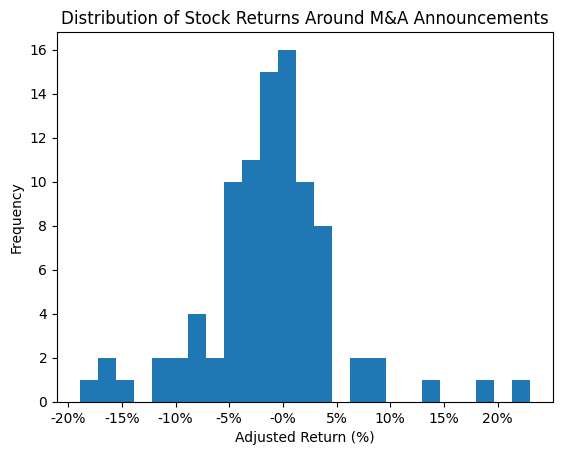

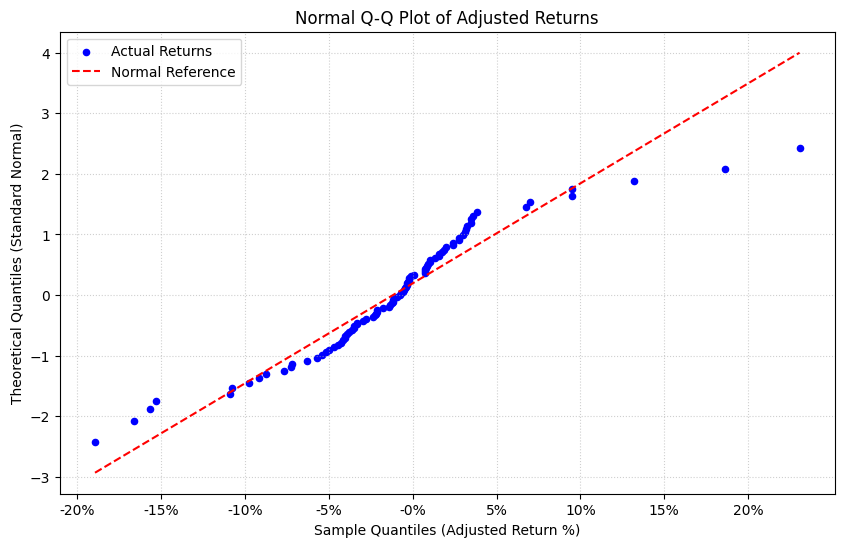

In [5]:
plt.figure()
plt.hist(returns, bins=25)
plt.xlabel("Adjusted Return (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Stock Returns Around M&A Announcements")
plt.xticks(np.arange(-0.20, 0.25, 0.05))
plt.gca().xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x*100:.0f}%")
)
plt.show()


# 1. Calculate quantiles
(osm, osr), (slope, intercept, r) = stats.probplot(returns, dist="norm", plot=None)

plt.figure(figsize=(10, 6))

# 2. Plotting
plt.scatter(osr, osm, color='blue', s=20, label="Actual Returns")
plt.plot(osr, (osr - intercept) / slope, color='red', linestyle='--', label="Normal Reference")

# 3. SET THE 5% INTERVALS
# Adjust the range (-0.20, 0.30) to fit your specific min/max returns
plt.xticks(np.arange(-0.20, 0.25, 0.05)) 

# 4. Formatting
plt.title("Normal Q-Q Plot of Adjusted Returns")
plt.xlabel("Sample Quantiles (Adjusted Return %)")
plt.ylabel("Theoretical Quantiles (Standard Normal)")

# Formatter for decimals
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()



The histogram shows that most adjusted returns cluster close to zero, indicating
short-term market reactions are typically small in magnitude for acquiring firms. While the distribution is centered slightly
below zero, extreme outcomes are uncommon.  The normal-QQ plot shows heavier tails compared to the standard normal distribution, but since we have a fairly large sample size of 91, it will help us with our normality assumption for our statistical methods later on.

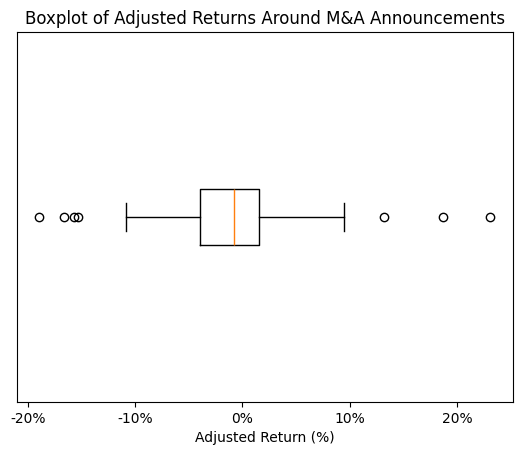

In [6]:
plt.figure()
plt.boxplot(returns, vert=False, showfliers=True)
plt.xlabel("Adjusted Return (%)")
plt.gca().set_yticks([])
plt.title("Boxplot of Adjusted Returns Around M&A Announcements")
plt.gca().xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x*100:.0f}%")
)
plt.show()


The boxplot shows that adjusted returns around M&A announcements are tightly clustered near zero. The median return is slightly negative and the interquartile range is narrow, indicating that most acquiring firms experience relatively small price movements on the announcement date.

While the overall pattern suggests stability, the plot reveals a small number of significant outliers. These represent "high-conviction" market reactions where investors deviate sharply from the norm based on deal-specific context. 

A clear example of a negative outlier is AbbVie’s 2019 acquisition of Allergan. While most acquiring firms in this dataset experienced small price movements on the announcement date, AbbVie’s shares fell by approximately 16%.

This sharp decline reflects investor concern over the size and structure of the deal. The acquisition was meant to provide diversification away from AbbVie’s dependence on Humira (their flagship drug whose patent was expiring soon), but it also increased debt, and Allergan itself had faced growth challenges, leading investors to question whether the acquisition sufficiently improved AbbVie’s long-term outlook. As a result, the market reacted negatively, viewing the deal as increasing financial and strategic risk rather than reducing it.

These isolated cases demonstrate that extreme price movements are rarely the result of general market trends, but are instead driven by specific concerns over strategic fit or financial overextension. Ultimately, the boxplot reinforces the histogram results: short-term market reactions to acquisition announcements are typically modest, with volatility reserved for special cases.

### Direction of Market Reaction

To better understand how often acquisition announcements are received positively or negatively,
we categorize each adjusted return as either positive or negative and examine their frequency.


62.6374% of samples are negative returns
37.3626% of samples are positive returns


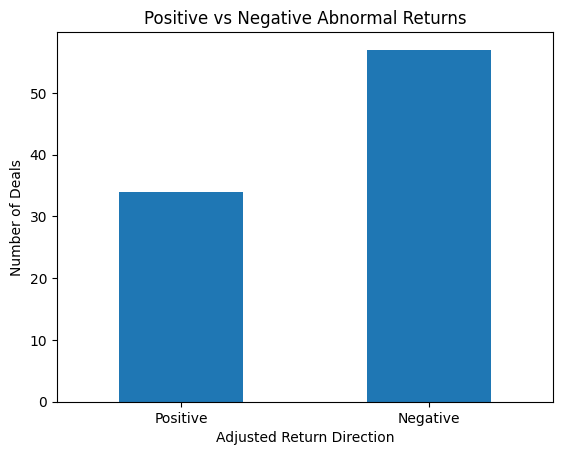

In [7]:
negative_percent = round((returns < 0).sum() / len(returns) * 100, 4)

print(f"{negative_percent}% of samples are negative returns")
print(f"{100-negative_percent}% of samples are positive returns")

counts = (returns < 0).value_counts().sort_index()
counts.plot(kind="bar")
plt.xticks([0,1], ["Positive", "Negative"], rotation=0)
plt.xlabel("Adjusted Return Direction")
plt.ylabel("Number of Deals")
plt.title("Positive vs Negative Abnormal Returns")
plt.show()

A majority of acquisitions in the sample are associated with negative adjusted returns on the
announcement date. On the surface level, this suggests that investors may be slightly cautious or skeptical toward
acquisition announcements by acquiring firms.  However, we will later be conducting a confidence interval for the adjusted return to explore this further.


### Sector-Level Variation

This section examines whether announcement-day adjusted returns differ across industry sectors.
We first compare average adjusted returns by sector, and then examine the full distribution of
returns within each sector.


In [8]:
sector_means = (
    df.groupby("Sector")["True_Adjusted_Return"]
      .mean()
      .sort_values()
      .to_frame(name="Mean Adjusted Return")
)

sector_means.style.format({"Mean Adjusted Return": "{:.2%}"})


,Mean Adjusted Return
Sector,
Healthcare,-3.16%
Technology,-2.24%
Industrials,-1.87%
Financials,-1.20%
Communication,-0.78%
Energy,0.47%
Consumer,1.02%


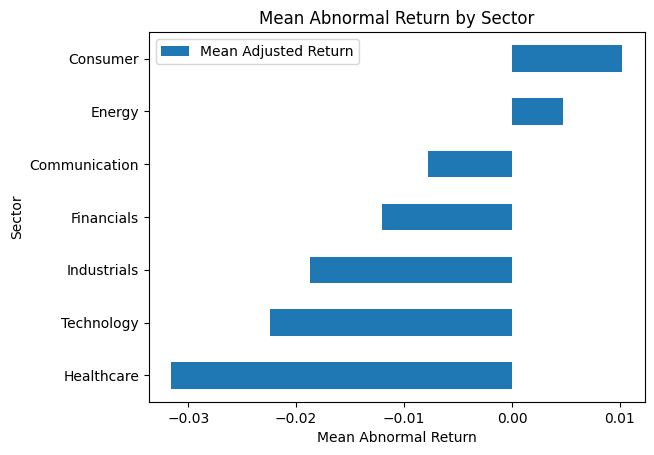

In [9]:
sector_means.plot(kind="barh")
plt.xlabel("Mean Abnormal Return")
plt.ylabel("Sector")
plt.title("Mean Abnormal Return by Sector")
plt.show()

The bar chart shows the **average adjusted return** for acquiring firms by sector.
Most sectors exhibit slightly negative mean returns on the announcement date.

Consumer-focused acquisitions show the highest sample mean adjusted return, while
Healthcare and Technology display the most negative averages. However, the differences
across sectors are relatively small in magnitude, suggesting that sector alone does not
strongly explain announcement-day stock reactions.

Overall, these results suggest that sector classification is associated with differences in
average outcomes, but sector alone does not strongly explain announcement-day adjusted returns.


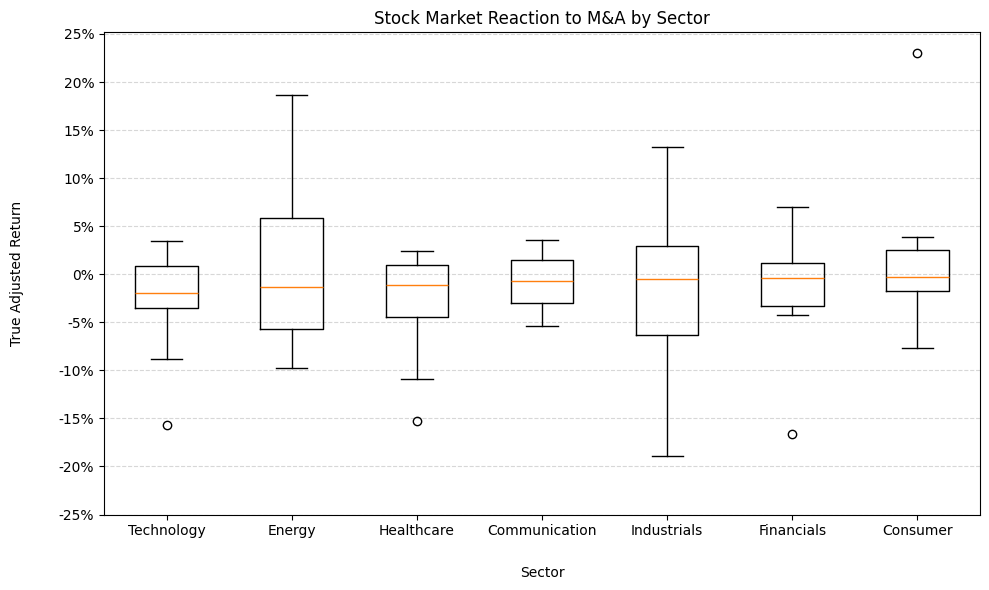

In [10]:
sector_order = (
    df.groupby("Sector")["True_Adjusted_Return"]
    .median()
    .sort_values()
    .index
)
data = []

# print(sectors)

for currSector in sector_order:
    # all rows with the currSector, and their true adjusted return
    curr_sector_data = df[df["Sector"] == currSector]
    true_avg_returns = curr_sector_data["True_Adjusted_Return"]

    # add to big 2D array of values
    data.append(true_avg_returns)

#print(data)

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=sector_order, showfliers=True)

# labels
plt.xlabel("Sector", labelpad=20)
plt.ylabel("True Adjusted Return", labelpad=25)
plt.title("Stock Market Reaction to M&A by Sector")

# This function takes the number (x) and returns a string with a % sign
def to_percent(x, position):
    return f'{x*100:.0f}%' # ".0f" means 0 decimal places (e.g., 10%)

# Apply the formatter to the Y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# set y-axis ticks
plt.yticks([-0.25, -0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15, 0.20, 0.25])

# dashed grid to look better :)
plt.grid(axis='y', linestyle='--', alpha=0.5) 

plt.tight_layout()
plt.show()

The boxplot provides a fuller view of sector-level variation by showing the distribution
of adjusted returns within each sector.

While median returns are generally close to zero across sectors, there is substantial
dispersion, with several extreme positive and negative outliers. This indicates that
individual deals can generate large market reactions regardless of sector, even though
average effects remain modest across all sectors.

Overall, sector appears to explain little of the systematic variation in announcement
returns.


Taken together, the mean comparison and boxplot suggest that sector classification
provides limited explanatory power for short-term market reactions. Although some
sectors show slightly higher or lower average returns, the wide spread of outcomes
within each sector implies that deal-specific factors dominate investor response.


### Regulatory Scrutiny and Market Reaction
We examine whether acquisitions that later faced regulatory scrutiny experienced different
announcement-day market reactions. A Welch two-sample t-test is used to compare adjusted returns
between scrutinized and non-scrutinized deals.

In [11]:
ftc = df[df["FTC_Scrutiny"] == 1]["True_Adjusted_Return"]
non_ftc = df[df["FTC_Scrutiny"]==0]["True_Adjusted_Return"]

# Welch t-test
t_stat, p_val =  stats.ttest_ind(ftc, non_ftc, equal_var=False)


print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.4f}")

t-statistic: -0.495
p-value: 0.6221


The Welch t-test finds no statistically significant difference in announcement-day adjusted
returns between acquisitions that later encountered regulatory scrutiny and those that did not
(p = 0.622).

This result suggests that investors, on average, do not appear to systematically price in the
risk of future regulatory intervention at the time of the acquisition announcement. One possible
explanation is that regulatory outcomes are difficult to anticipate so early and that it is overlooked by many in the
announcement stage.


### Average Market Reaction

We estimate the average announcement-day adjusted return across all acquisitions and construct a
95% confidence interval to assess whether the average market reaction differs from zero.

In [12]:
returns = df["True_Adjusted_Return"]
mean = returns.mean()
se = stats.sem(returns)

ci = stats.t.interval(
    0.95,
    len(returns)-1,
    loc=mean,
    scale=se
)

lb, ub = ci

print(f"Mean Adjusted Return: {mean:.4f}")
print(f"95% Confident Interval: ({lb}, {ub})")


Mean Adjusted Return: -0.0116
95% Confident Interval: (-0.024672240196845035, 0.00138432810893295)


The sample mean announcement-day adjusted return across all acquisitions is −1.16%.
The 95% confidence interval includes zero, indicating that the average market reaction is not
statistically different from zero.

This suggests that, there is no
strong evidence of a systematic positive or negative average effect across acquisitions.


## Logistic Regression Analysis

This section models the probability that an acquisition announcement results in a positive
adjusted return for the acquiring firm. Logistic regression is used to relate the likelihood
of a positive return to observable deal characteristics.

Estimated coefficients are interpreted using odds ratios.


In [13]:
df["Is_Pos_Return"] = (df["True_Adjusted_Return"] > 0).astype(int)

y = df["Is_Pos_Return"].astype(int)

x = df[[
    "Relative_Deal_Size",
    "Sector",
    "Deal_Type"
]]

x = pd.get_dummies(x, drop_first=True)
x = x.astype(float)
x = sm.add_constant(x)

logit = sm.Logit(y, x)
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.608661
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Is_Pos_Return   No. Observations:                   91
Model:                          Logit   Df Residuals:                       82
Method:                           MLE   Df Model:                            8
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                 0.07898
Time:                        16:03:24   Log-Likelihood:                -55.388
converged:                       True   LL-Null:                       -60.138
Covariance Type:            nonrobust   LLR p-value:                    0.3019
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.4854      1.029     -1.444      0.149      -3.502       0.531
Relat

The model indicates very little evidence of any relations, with a pseudo R² of approximately 0.08, and overall model p-value of 0.30, indicating no real statistical signifcance.
This suggests that most of the variation in announcement-day returns remains unexplained by any of the variables catpured.

Among the included variables, relative deal size seems to be the only statistically significant predictor
of a positive adjusted return, with a coefficent of 0.80 and p-value of 0.016


To aid interpretation, coefficients are converted into odds ratios with corresponding
95% confidence intervals.


In [14]:
or_df = pd.DataFrame({
    "OR": np.exp(result.params),
    "95% CI low": np.exp(result.conf_int()[0]),
    "95% CI high": np.exp(result.conf_int()[1]),
    "p-value": result.pvalues
})

or_df

,OR,95% CI low,95% CI high,p-value
const,0.226405,0.030131,1.701236,0.148857
Relative_Deal_Size,2.235492,1.164621,4.291029,0.015605
Sector_Consumer,1.137242,0.181303,7.133461,0.890813
Sector_Energy,1.219746,0.126823,11.731157,0.863440
Sector_Financials,1.786672,0.279635,11.415564,0.539666
Sector_Healthcare,0.951986,0.152651,5.936907,0.957980
Sector_Industrials,1.332090,0.108004,16.429620,0.822988
Sector_Technology,1.373735,0.184082,10.251677,0.756832
Deal_Type_Consumer,1.466198,0.356222,6.034825,0.596042



While the overall model did not reach statistical significance ($p = 0.30$), Relative Deal Size emerged as a significant individual predictor.

Specifically, larger relative deals are associated with higher odds of a positive return, with an odds ratio of 2.23 (AKA a one-unit increase in relative deal size more than doubles the odds
of a positive market reaction.) Sector-specific effects and deal types did not show a significant relationship with the direction of returns.


## Machine Learning Models

The goal of this section is not to maximize predictive accuracy, but to assess whether
prediction-focused and nonlinear models can extract additional signal from observable deal
characteristics beyond traditional logistic regression.


### Logistic Regression (Prediction-Oriented)

As a benchmark, we first evaluate a prediction-oriented logistic regression model using a
train–test split. Model performance is assessed using the confusion matrix and the area
under the ROC curve (AUC).


In [15]:
df["Is_Pos_Return"] = (df["True_Adjusted_Return"] > 0).astype(int)


x = df[
    ["Relative_Deal_Size", "Sector", "Deal_Type"]
]

y = df["Is_Pos_Return"]

x = pd.get_dummies(x, drop_first = True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, stratify=y)


# Befrore scaling: Relative_Deal_Size: 0.2 – 3.5  | Sector dummy: 0 or 1
# After scaling:   Relative_Deal_Size  -1.2 - 2.1 | Sector_dummy -0.7 to 1.4
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:


logistic_model = LogisticRegression(max_iter = 1000)
logistic_model.fit(x_train_scaled, y_train)

y_prediction_log = logistic_model.predict(x_test_scaled)
y_prob_log = logistic_model.predict_proba(x_test_scaled)[:, 1] # threshold of 0.5
# print(X_test)

# print(y_prediction_log)
# print()
# print(y_prob_log) 



roc_auc_logistic = roc_auc_score(y_test, y_prob_log)


print(f"Confusion matrix: \n{confusion_matrix(y_test, y_prediction_log)}")
print(f"Area under ROC curve with logistic regression model: {roc_auc_logistic}")


# TN FP
# FN TP


Confusion matrix: 
[[9 3]
 [6 1]]
Area under ROC curve with logistic regression model: 0.39285714285714285


*The format of the confusion matrix is:    
TN FP  
FN TP*

The logistic regression model achieves an AUC of 0.50, which is no better than random
classification. This further highlights the difficulty of predicting short-term stock price reactions
using publicly observable deal characteristics.

The confusion matrix shows that the model correctly identifies most negative-return deals but
fails to detect the majority of positive-return cases, resulting in a high false-negative rate.


### Random Forest Model

We next try a random forest model to see if we can improve predictive performance at all.


In [17]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5)
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)
y_prob_rf = rf_model.predict_proba(x_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# TN FP
# FN TP
print(f"Confusion matrix: \n{confusion_matrix(y_test, y_pred_rf)}")
print(f"Area under ROC curve with random forest model: {roc_auc_rf}")



Confusion matrix: 
[[9 3]
 [4 3]]
Area under ROC curve with random forest model: 0.4880952380952381


The random forest model modestly improves predictive performance, achieving an AUC of approximately
0.63. This suggests the presence of weak nonlinear relationships in the data, although overall
predictive accuracy still remains limited and unclear. 

To visualize the difference in the ROC curves, we have the following graph:


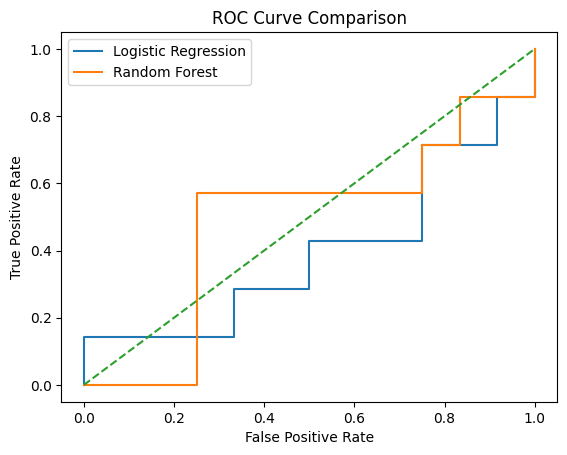

In [18]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()

Despite the improvement, both classifiers exhibit limited
power. This reinforces the conclusion that short-term announcement returns
are inherently difficult to predict using simple and general deal characteristics.


In [19]:
importances = pd.Series(
    rf_model.feature_importances_,
    index=x.columns
).sort_values(ascending=False)

importances

Relative_Deal_Size    0.787947
Deal_Type_Consumer    0.062993
Sector_Healthcare     0.034417
Sector_Technology     0.029962
Sector_Financials     0.022744
Sector_Industrials    0.021203
Sector_Energy         0.020779
Sector_Consumer       0.019955
dtype: float64

Feature importance rankings reinforce earlier findings, with relative deal size dominating
other variables. Sector and deal type contribute comparatively little predictive information.


### Model Comparison

While Random Forest improves predictive performance relative to logistic regression, overall
accuracy remains modest. This suggests that short-term market reactions are influenced primarily
by factors not captured in surface level deal characteristics.

## Conclusion

This project finds little to no evidence that any of the observable deal characteristics studied can reliably explain or
predict short-term market reactions to M&A announcements for acquiring firms. Relative deal size
shows the strongest association, while sector and deal type contribute little explanatory power.

The random forest model modestly outperforms logistic regression but still achieves low predictive
accuracy, highlighting the role of unobserved factors such as context-specific information,
and other investor expectations for the specific acquiring firm.

These findings are consistent with prior research showing that short-term stock price reactions for acquiring firms are difficult to explain using observable deal characteristics. Andrade, Mitchell, and Stafford (2001) note that “the evidence on value creation for acquiring firm shareholders is not so clear cut,” and that acquirer announcement-day returns are typically small and statistically insignificant. In an efficient market, stock prices “quickly adjust following a merger announcement, incorporating any expected value changes,” which limits the ability to extract predictive signal from publicly available information alone. As the authors emphasize, a return near zero “reflects a fair rate of return on the merger investment from the acquirer’s point of view.” This suggests that investors often see acquisitions as fairly valued at announcement, leading to small stock price reactions. As a result, observable deal characteristics provide limited predictive power.



## Limitations

The sample size is relatively small (N = 91), which may limit the strength of statistical conclusions.

Several important factors are not observed or included, such as how the deal was financed, whether the market anticipated the acquisition, or broader economic conditions.